In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
from pathlib import Path
import optuna
import numpy as np

from utils.data import load_config_xval_test_set, load_xval_test_set
from utils.analysis import xval_station_metrics, get_cdf
from utils.metrics import compute_metrics
from utils.plotting import load_default_mpl_config, savefig

load_default_mpl_config()

PLOT_PATH = Path('/mydata/machflow/basil/mach-flow/analysis/model_vis/')
runoff_vars = ['Qmm', 'Qmm_mod', 'Qmm_prevah']

def merged_df(mod, prevah):
    x_mod = mod.to_dataframe().reset_index()
    x_mod['source'] = 'mod'
    x_pre = prevah.expand_dims(dummy=1).to_dataframe().reset_index().drop(columns=['dummy'])
    x_pre['model'] = 'PREVAH'
    x_pre['source'] = 'prevah'
    x_both = pd.concat((x_mod, x_pre)).reset_index()

    return x_both

/mydata/machflow/basil/mambaforge/envs/machflow/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xval_ds = xval_station_metrics(
    '../../runs/basin_level/', metrics=['nse'], time=slice('2012', None))

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


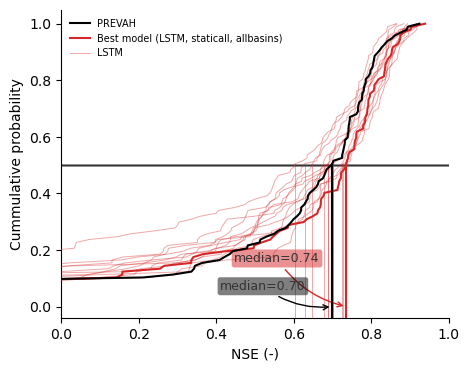

In [5]:

class ModelColors(object):
    def __init__(self, cmap: str = 'tab10'):
        self.cmap = plt.get_cmap(cmap)
        self.i = 0

    def __next__(self) -> tuple:
        color = self.cmap(self.i)
        self.i += 1
        return color

metrics = list(xval_ds.data_vars)
num_metrics = len(metrics)
ref = 'prevah'

fig, axes = plt.subplots(
    1, num_metrics, figsize=(5, 4), sharey='row', squeeze=False,
    gridspec_kw={'hspace': 0.2})


for i, metric in enumerate(metrics):

    da = xval_ds[metric]
    rel_metrics = da - da.sel(run=ref)
    lstm_colors = ModelColors(cmap='Paired')
    tcn_colors = ModelColors(cmap='Paired')

    for run in da.run.values:

        if run == ref:
            col = 'k'
            style = '-'
            zorder = 10
            lw = 1.5
            alpha = 1
            add_annot = 10
            label = 'PREVAH'
        else:
            zorder = 8
            lw = 0.7
            alpha = 0.4
            add_annot = 0
            if run.startswith('TCN'):
                # col = next(tcn_colors)
                # style = ':'
                col = 'tab:blue'
                style = '-'
                label = 'TCN'
            else:
                # col = next(lstm_colors)
                # style = '--'
                col = 'tab:red'
                style = '-'
                label = 'LSTM'

            if run == 'LSTM-staticall_allbasins':
                # col = 'tab:green'
                alpha = 1
                lw = 1.5
                zorder = 9
                add_annot = 30
                label = 'Best model (LSTM, staticall, allbasins)'

        # CDF plots
        # ----------------
        ax = axes[0, i]
        ax.spines[['right', 'top']].set_visible(False)
        ax.set_xlabel(metric)

        bins, cdf, xloc = get_cdf(da.sel(run=run))

        ax.plot(bins, cdf, label=label, color=col, alpha=alpha, lw=lw, zorder=zorder,
                ls=style)
        ax.axvline(xloc, ymin=0, ymax=0.5, color=col, ls=style, alpha=alpha, lw=lw, zorder=zorder)
        ax.axhline(0.5, color='0.2', ls=style, alpha=1.0, lw=0.8, zorder=0)

        if metric in ['nse', 'kge']:
            ax.set_xlim(0, 1)
        elif metric == 'absbias':
            ax.set_xlim(0, 2)

        annot_kwargs = dict(
            textcoords='offset points', ha='center', va='bottom', color='0.2',
            fontsize=9
        )

        if add_annot:
            ax.annotate(
                f'median={xloc:0.2f}', xy=(xloc, 0),
                xytext=(-50,add_annot),
                bbox=dict(boxstyle='round,pad=0.2', fc=col, ec='none', alpha=0.5),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.2', color=col, alpha=1.0),
                zorder=zorder,
                **annot_kwargs)

        if metric == 'nse':
            mname = 'NSE (-)'
        else:
            mname = 'not defined (-)'

        ax.set_xlabel(mname)

axes[0, 0].set_ylabel('Cummulative probability')

handles, labels = axes[0, 0].get_legend_handles_labels()
handle_list, label_list = [], []
# order = [1, 2, 0, 3]
order = [1, 2, 0]
for handle, label in zip(handles, labels):
    if label not in label_list:
        handle_list.append(handle)
        label_list.append(label)
axes[0, 0].legend(
    [handle_list[idx] for idx in order],
    [label_list[idx] for idx in order],
    frameon=False,
    fontsize=7,
    loc='upper left',
    bbox_to_anchor=(0, 1))

savefig(fig, path=PLOT_PATH / 'model_comp.png')

In [4]:
def config_to_tune_path(df: pd.DataFrame) -> pd.DataFrame:
    df['fusion_method'] = ''

    for i in range(len(df)):
        el = df.iloc[i, :]

        s = []
        if el['static'] == 'all':
            s += ['staticall']
        elif el['static'] == 'dred':
            s += ['staticdred']

        if el['allbasins']:
            s += ['allbasins']

        if el['sqrttrans']:
            s += ['sqrttrans']

        if len(s) == 0:
            s = ['default']

        config = "_".join(s)
        model = el['model']

        optuna_path = f'sqlite:///../../runs/basin_level/{config}/{model}/tune/optuna.db'
        study = optuna.load_study(study_name=model, storage=optuna_path)
        fusion_method = study.best_params['fusion_method']

        df.loc[i, 'fusion_method'] = fusion_method

    return df

In [5]:
xval_ds = load_config_xval_test_set(
    path='/mydata/machflow/basil/runs/basin_level/',
    nonbool_kwords=['static'],
    time=slice('2012', None)).drop_vars('tau')
met_ds = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_mod,
    metrics='all',
    dim='time').median(dim='station').compute()

In [6]:
xval_df = met_ds.nse.to_dataframe().reset_index()
xval_df = config_to_tune_path(xval_df)

In [7]:
configs = [
    col for col in xval_df.columns if (not pd.api.types.is_numeric_dtype(xval_df[col]) or xval_df[col].dtypes == bool) and col != 'fusion_method'
]
configs

['allbasins', 'sqrttrans', 'static', 'model']

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


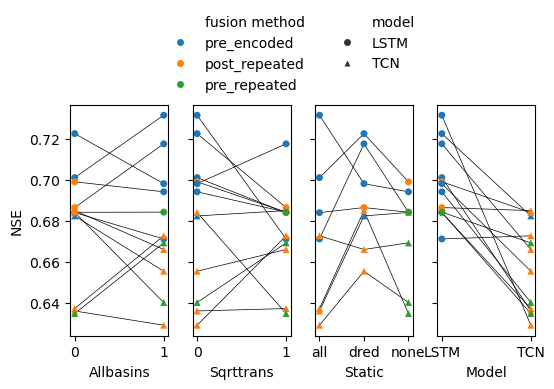

In [28]:

fig, axes = plt.subplots(
    1, len(configs), figsize=(6, 3), sharex='col', sharey='row',
    gridspec_kw={'wspace': 0.25})

for c, cvar in enumerate(configs):
    ax = axes[c]
    
    im = sns.scatterplot(
        x=cvar,
        y='nse',
        data=xval_df.rename(columns={'fusion_method': 'fusion method'}),
        hue='fusion method',
        style='model',
        legend=c==1,
        markers=['o', '^'],
        edgecolor='none',
        s=25,
        ax=ax,
    )

    if c == 1:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False,
        )

    data = ax.collections[0].get_offsets().data
    n_x = len(np.unique(data[:, 0]))

    for i in range(n_x - 1):
        data0 = data[np.argwhere(data[:, 0] == i)[:, 0], :]
        data1 = data[np.argwhere(data[:, 0] == i + 1)[:, 0], :]

        for l in range(data0.shape[0]):
            ax.plot([data0[l][0], data1[l][0]], [data0[l][1], data1[l][1]], color='k', lw=0.5, ls='-', zorder=-1)

    # axc = ax.collections
    # for a in axc[::2]:
    #     a.set_paths([triangle_up_mk])
    # for a in axc[1::2]:
    #     a.set_paths([square_mk])

    # if c==1:
    #     ax.legend(axc[-2:], pd.unique(xval_df.model),
    #         loc='lower center',
    #         bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False,)

    # for i in range(len(ax.collections) - 1):
    #     coll0 = ax.collections[i].get_offsets().data
    #     coll1 = ax.collections[i + 1].get_offsets().data

    #     for l in range(coll0.shape[0]):
    #         ax.plot([coll0[l][0], coll1[l][0]], [coll0[l][1], coll1[l][1]], color='k', lw=1, ls='-')


    ax.set_xlabel(cvar)

    if c == 0:
        ax.set_ylabel('NSE')
    else:
        ax.set_ylabel('')

    ax.set_xlabel(ax.get_xlabel().capitalize())

savefig(fig, path=PLOT_PATH / 'model_factors.png')

In [81]:
mod = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_mod,
    metrics='all',
    dim='time').mean(dim='station').compute()
prevah = compute_metrics(
    obs=xval_ds.Qmm,
    mod=xval_ds.Qmm_prevah,
    metrics='all',
    dim='time').mean(dim='station').compute()

xr_df_mean = merged_df(mod, prevah)

<Axes: xlabel='model', ylabel='bias2'>

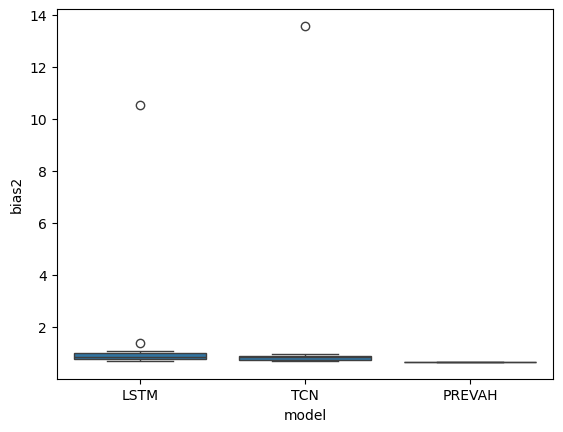

In [89]:
sns.boxplot(x='model', y='bias2',data=xr_df_mean)

/mydata/machflow/basil/mach-flow/utils/plotting.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


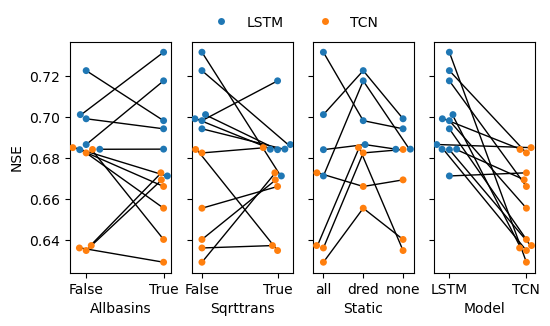

In [ ]:

fig, axes = plt.subplots(
    1, len(configs), figsize=(6, 3), sharex='col', sharey='row',
    gridspec_kw={'wspace': 0.2})

for c, cvar in enumerate(configs):
    ax = axes[c]

    ax = sns.swarmplot(
        x=cvar,
        y='nse',
        data=xval_df,
        dodge=False,
        hue='model',
        legend=c==1,
        ax=ax,
        )

    if c == 1:
        sns.move_legend(
            ax, "lower center",
            bbox_to_anchor=(1, 1), ncol=2, title=None, frameon=False,
        )

    for i in range(len(ax.collections) - 1):
        coll0 = ax.collections[i].get_offsets().data
        coll1 = ax.collections[i + 1].get_offsets().data

        for l in range(coll0.shape[0]):
            ax.plot([coll0[l][0], coll1[l][0]], [coll0[l][1], coll1[l][1]], color='k', lw=1, ls='-')

    ax.set_xlabel(cvar)

    if c == 0:
        ax.set_ylabel('NSE')
    else:
        ax.set_ylabel('')

    ax.set_xlabel(ax.get_xlabel().capitalize())

savefig(fig, path=PLOT_PATH / 'model_factors.png')

Text(0.5, 24.0, 'Model')

In [2]:
xval_ds = load_config_xval_test_set(
    path='/mydata/machflow/basil/runs/basin_level/', nonbool_kwords=['static']).drop_vars('tau')
met_ds = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics='all', dim='time')
met_ds_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics='all', dim='time')
met_ds_glob = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_mod, metrics=['mse'], dim=None)
met_ds_glob_p = compute_metrics(obs=xval_ds.Qmm, mod=xval_ds.Qmm_prevah, metrics=['mse'], dim=None)

In [19]:
best_ds = load_xval_test_set('../../runs/basin_level/default/LSTM/xval/')[runoff_vars].sel(tau=0.5).drop_vars('tau')
met_ds_best = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_mod, dim='time')
met_ds_best_p = compute_metrics(best_ds.Qmm, mod=best_ds.Qmm_prevah, dim='time')

In [23]:
all_metrics = list(met_ds_best.data_vars)
x_mod = met_ds_best.to_dataframe().reset_index()
x_mod['source'] = 'mod'
x_pre = met_ds_best_p.to_dataframe().reset_index()
x_pre['source'] = 'prevah'
x_both = pd.concat((x_mod, x_pre))

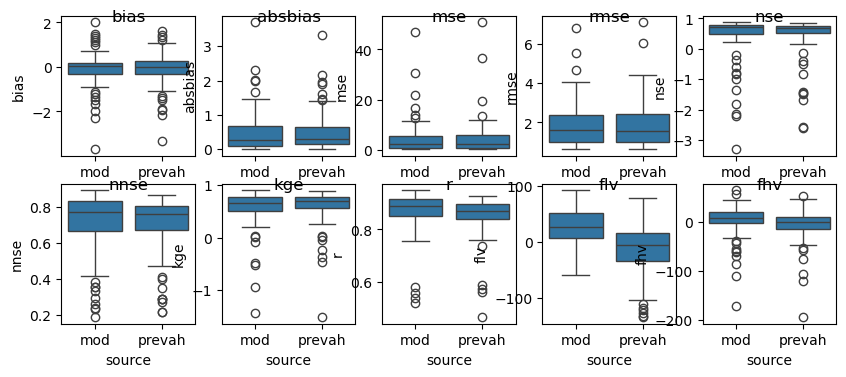

In [24]:
n = len(all_metrics)

n_cols = n // 2
n_rows = math.ceil(n / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))

for i, metric in enumerate(all_metrics):
    ax = axes.flatten()[i]
    sns.boxplot(x='source', y=metric, data=x_both, ax=ax)
    ax.set_title(metric, y=0.9)